### Multiclass Classification

In [50]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

from sklearn.model_selection import train_test_split

from tscls.dataloaders import TimeSeriesLoader

data_paths = {
    0: Path("../data/Si_wafer_clear_SRRs"),
    1: Path("../data/SRRs_cleaned_with_ethanol"),
    2: Path("../data/SRRs_with_10ppb_Acetamiprid"),
    3: Path("../data/SRRs_with_100ppb_Acetamiprid"),
    4: Path("../data/SRRs_with_1000ppb_Acetamiprid"),
    5: Path("../data/SRRs_with_10000ppb_Acetamiprid"),
    6: Path("../data/SRRs_with_100000ppb_Acetamiprid"),
}

tsl = TimeSeriesLoader(data_paths)

X, y = tsl.load()

tsl.report()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Loading data from 7 categories...
Processing complete: 560 samples found.
Max series length: 4001

DATASET REPORT
Total Samples:    560
Series Length:    4001
Channels:         1
----------------------------------------
Class Distribution:
Label      Count      Percentage
0          80         14.3%
1          80         14.3%
2          80         14.3%
3          80         14.3%
4          80         14.3%
5          80         14.3%
6          80         14.3%
----------------------------------------
Running tsai.check_data()...

X      - shape: [560 samples x 1 features x 4001 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (560,)  type: ndarray  dtype:int64  isnan: 0



In [51]:
from aeon.classification.convolution_based import RocketClassifier
from tsai.all import (
    InceptionTime,
    InceptionTimePlus,
    ResNet,
    XceptionTime,
)

from tscls.experiments import AeonExperiment, TsaiExperiment

tsai_exp = TsaiExperiment(X=X, y=y, random_state=42)
aeon_exp = AeonExperiment(X=X, y=y, random_state=42)

# OmniScaleCNN excluded because it is very slow to train
results = [
    tsai_exp.train(InceptionTimePlus, "InceptionTimePlus", epochs=85),
    tsai_exp.train(InceptionTime, "InceptionTime", epochs=85),
    tsai_exp.train(ResNet, "ResNet", epochs=85),
    tsai_exp.train(XceptionTime, "XceptionTime", epochs=85),
]

results += [aeon_exp.train(RocketClassifier, "Rocket", n_kernels=10000)]

tsai_exp.print_summary(results)


Training InceptionTimePlus (Tsai)...
----------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,1.956615,1.946299,0.133929,01:23
1,1.951097,1.945094,0.133929,01:19
2,1.946238,1.940814,0.107143,01:18
3,1.940788,1.929446,0.107143,01:15
4,1.931714,1.909580,0.125000,01:12
5,1.916892,1.909776,0.125000,01:16
6,1.892950,1.802662,0.258929,01:21
7,1.855690,1.803331,0.232143,01:20
8,1.818522,2.882681,0.125000,01:20
9,1.768358,1.773632,0.267857,01:20


Done. Acc: 0.5982 | Loss: 0.7967

Training InceptionTime (Tsai)...
----------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,1.951251,1.953487,0.133929,01:14
1,1.948536,1.954114,0.133929,01:14
2,1.946527,1.952486,0.133929,01:14
3,1.943326,1.946983,0.133929,01:15
4,1.934873,1.934413,0.125000,01:14
5,1.916425,1.846282,0.294643,01:13
6,1.891525,1.821265,0.276786,01:14
7,1.854109,1.712321,0.303571,01:13
8,1.805443,1.602523,0.312500,01:13
9,1.758576,1.581383,0.339286,01:13


Done. Acc: 0.5893 | Loss: 0.8158

Training ResNet (Tsai)...
----------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,1.950649,1.944367,0.169643,00:36
1,1.946369,1.944357,0.107143,00:36
2,1.942834,1.942782,0.107143,00:36
3,1.938615,1.938382,0.133929,00:36
4,1.932282,1.929883,0.125000,00:36
5,1.921650,1.895186,0.142857,00:36
6,1.905132,1.843625,0.187500,00:36
7,1.880389,1.795361,0.303571,00:36
8,1.849848,1.725755,0.348214,00:36
9,1.812199,1.639008,0.312500,00:36


Done. Acc: 0.5804 | Loss: 0.9650

Training XceptionTime (Tsai)...
----------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,1.935437,1.939250,0.169643,01:08
1,1.926295,1.940762,0.142857,01:08
2,1.917144,1.939692,0.142857,01:08
3,1.908363,1.906103,0.267857,01:08
4,1.896366,1.881746,0.285714,01:08
5,1.885905,1.890575,0.232143,01:08
6,1.874173,1.902021,0.241071,01:08
7,1.870376,1.861231,0.205357,01:07
8,1.864760,1.841056,0.330357,01:07
9,1.860741,1.849826,0.410714,01:06


Done. Acc: 0.6607 | Loss: 1.3791

Training Rocket (Aeon)...
----------------------------------------
Done. Acc: 0.7411


                   FINAL COMPARISON                    
Model Name                | Accuracy   | Loss      
-------------------------------------------------------
Rocket                    | 0.7411     | 9.3327    
XceptionTime              | 0.6607     | 1.3791    
InceptionTimePlus         | 0.5982     | 0.7967    
InceptionTime             | 0.5893     | 0.8158    
ResNet                    | 0.5804     | 0.9650    



### Multiclass ROC plots

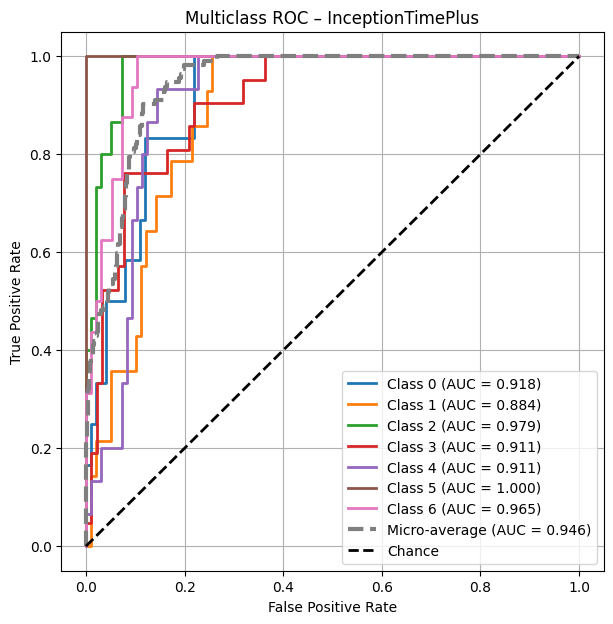

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# -------------------------------------------------
# Select model result
# -------------------------------------------------
res = results[0]   # change index to select model
model = res.model

# -------------------------------------------------
# Get scores and true labels
# -------------------------------------------------
if hasattr(model, "get_preds"):
    # tsai / fastai models
    probs, y_true = model.get_preds()
    y_proba = probs.cpu().numpy()
    y_true = y_true.cpu().numpy()
    classes = np.arange(y_proba.shape[1])

elif hasattr(model, "predict_proba"):
    # sklearn / sktime / aeon-style models
    proba = model.predict_proba(X_test)
    y_true = np.asarray(y_test)

    if hasattr(proba, "to_numpy") and hasattr(proba, "columns"):
        # pandas DataFrame: columns are class labels
        y_proba = proba.to_numpy()
        classes = np.asarray(proba.columns)
    else:
        # numpy array
        y_proba = np.asarray(proba)
        classes = np.asarray(getattr(model, "classes_", np.unique(y_true)))

else:
    raise TypeError(f"Unsupported model type: {type(model)}")

# -------------------------------------------------
# Multiclass ROC (One vs Rest)
# -------------------------------------------------
y_true_bin = label_binarize(y_true, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(7, 7))

# Per-class ROC curves
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(
        y_true_bin[:, i],
        y_proba[:, i]
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label=f"Class {cls} (AUC = {roc_auc[i]:.3f})"
    )

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(),
    y_proba.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(
    fpr["micro"],
    tpr["micro"],
    linestyle="--",
    linewidth=3,
    label=f"Micro-average (AUC = {roc_auc['micro']:.3f})"
)

# -------------------------------------------------
# Plot formatting
# -------------------------------------------------
plt.plot([0, 1], [0, 1], "k--", lw=2, label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multiclass ROC – {res.name}")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Binary Classification

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tsai.all import accuracy
from sklearn.metrics import roc_auc_score
from tsai.metrics import RocAucBinary


from collections import Counter

data_paths = {
    0: Path("../data/Si_wafer_clear_SRRs"),
    1: Path("../data/SRRs_cleaned_with_ethanol"),
    2: Path("../data/Si_wafer_with_ethanol"),
    3: Path("../data/SRRs_with_10ppb_Acetamiprid"),
    4: Path("../data/SRRs_with_100ppb_Acetamiprid"),
    5: Path("../data/SRRs_with_1000ppb_Acetamiprid"),
    6: Path("../data/SRRs_with_10000ppb_Acetamiprid"),
    7: Path("../data/SRRs_with_100000ppb_Acetamiprid"),
}

# Define binary mapping
binary_map = {
    0: 0,  # Clear
    1: 0,  # Ethanol
    2: 0,  # Ethanol
    3: 0,  # 10ppb
    4: 1,  # 100ppb
    5: 1,  # 1000ppb
    6: 1,  # 10000ppb
    7: 1,  # 100000ppb
}
tsl = TimeSeriesLoader(data_paths)

X, y = tsl.load()

tsl.report()

y_binary = np.array([binary_map[label] for label in y])

print("Binary label distribution:", Counter(y_binary))



X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

Loading data from 8 categories...
Processing complete: 640 samples found.
Max series length: 4001

DATASET REPORT
Total Samples:    640
Series Length:    4001
Channels:         1
----------------------------------------
Class Distribution:
Label      Count      Percentage
0          80         12.5%
1          80         12.5%
2          80         12.5%
3          80         12.5%
4          80         12.5%
5          80         12.5%
6          80         12.5%
7          80         12.5%
----------------------------------------
Running tsai.check_data()...

X      - shape: [640 samples x 1 features x 4001 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (640,)  type: ndarray  dtype:int64  isnan: 0

Binary label distribution: Counter({np.int64(0): 320, np.int64(1): 320})


In [26]:
from aeon.classification.convolution_based import RocketClassifier
from tsai.all import (
    InceptionTime,
    InceptionTimePlus,
    ResNet,
    XceptionTime,
)

from tscls.experiments import AeonExperiment, TsaiExperiment

tsai_exp = TsaiExperiment(X=X, y=y_binary, random_state=42)
aeon_exp = AeonExperiment(X=X, y=y_binary, random_state=42)

# OmniScaleCNN excluded because it is very slow to train
results = [
    tsai_exp.train(InceptionTimePlus, "InceptionTimePlus", epochs=100),
    tsai_exp.train(InceptionTime, "InceptionTime", epochs=100),
    tsai_exp.train(ResNet, "ResNet", epochs=100),
    tsai_exp.train(XceptionTime, "XceptionTime", epochs=100),
]

results += [aeon_exp.train(RocketClassifier, "Rocket", n_kernels=10000)]

tsai_exp.print_summary(results)


Training InceptionTimePlus (Tsai)...
----------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.693746,0.693660,0.453125,01:23
1,0.691994,0.694824,0.453125,01:22
2,0.690620,0.694911,0.531250,01:22
3,0.689577,0.697249,0.523438,01:21
4,0.687636,0.687741,0.554688,01:22
5,0.685928,0.754754,0.453125,01:24
6,0.685024,0.675629,0.585938,01:33
7,0.684255,0.682644,0.554688,01:30
8,0.682693,0.864534,0.453125,01:30
9,0.681142,0.682706,0.546875,01:31


Done. Acc: 0.6094 | Loss: 0.6535

Training InceptionTime (Tsai)...
----------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.694407,0.695758,0.453125,01:24
1,0.692926,0.696121,0.453125,01:21
2,0.692024,0.693390,0.515625,01:22
3,0.690444,0.690678,0.531250,01:23
4,0.688353,0.723395,0.453125,01:23
5,0.685734,0.708089,0.523438,01:22
6,0.682953,1.300825,0.453125,01:22
7,0.680837,0.663799,0.570312,01:22
8,0.678765,0.662131,0.562500,01:23
9,0.675883,0.767902,0.507812,01:22


Done. Acc: 0.8359 | Loss: 0.3833

Training ResNet (Tsai)...
----------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.695224,0.689869,0.546875,00:40
1,0.693179,0.692543,0.546875,00:40
2,0.692241,0.693072,0.539062,00:40
3,0.690978,0.693264,0.546875,00:40
4,0.689308,0.689298,0.523438,00:40
5,0.688483,0.684471,0.539062,00:40
6,0.686975,0.686550,0.562500,00:41
7,0.683850,0.678801,0.546875,00:41
8,0.680379,0.664063,0.546875,00:41
9,0.679627,0.666894,0.593750,00:41


Done. Acc: 0.7344 | Loss: 0.5720

Training XceptionTime (Tsai)...
----------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,0.689136,0.708915,0.453125,01:15
1,0.685494,0.697283,0.453125,01:15
2,0.682837,0.691198,0.453125,01:15
3,0.679876,0.693235,0.453125,01:16
4,0.677224,0.676132,0.609375,01:15
5,0.676822,0.678818,0.656250,01:15
6,0.675735,0.685322,0.539062,01:14
7,0.676615,0.678902,0.570312,01:15
8,0.676946,0.682954,0.601562,01:15
9,0.675284,0.675595,0.617188,01:16


Done. Acc: 0.7188 | Loss: 0.5953

Training Rocket (Aeon)...
----------------------------------------
Done. Acc: 0.8828


                   FINAL COMPARISON                    
Model Name                | Accuracy   | Loss      
-------------------------------------------------------
Rocket                    | 0.8828     | 4.2239    
InceptionTime             | 0.8359     | 0.3833    
ResNet                    | 0.7344     | 0.5720    
XceptionTime              | 0.7188     | 0.5953    
InceptionTimePlus         | 0.6094     | 0.6535    



### Binary ROC plots

InceptionTime AUC: 0.9264


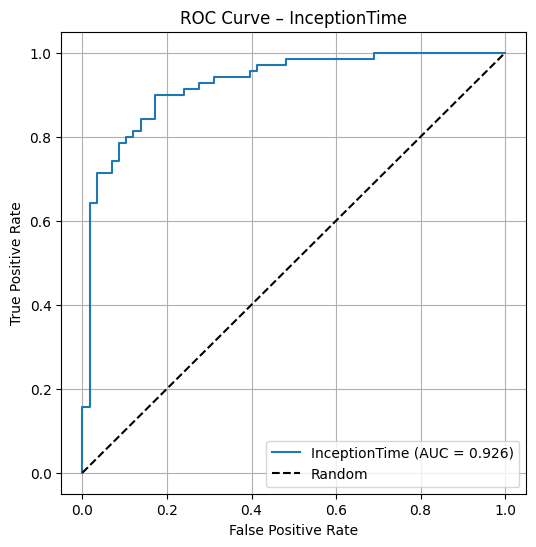

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Select model result
res = results[1]   

model = res.model

# -------------------------------------------------
# tsai / fastai model
# -------------------------------------------------
if hasattr(model, "get_preds"):
    # fastai Learner
    probs, y_true = model.get_preds()
    probs = probs.cpu().numpy()
    y_true = y_true.cpu().numpy()

    # Handle sigmoid vs softmax
    if probs.ndim == 2 and probs.shape[1] == 1:
        y_score = probs[:, 0]
    elif probs.ndim == 2 and probs.shape[1] == 2:
        y_score = probs[:, 1]
    else:
        raise ValueError(f"Unexpected probs shape: {probs.shape}")

# -------------------------------------------------
# aeon / ROCKET (sklearn-style)
# -------------------------------------------------
elif hasattr(model, "predict_proba"):
    y_score = model.predict_proba(X_test)[:, 1]
    y_true = y_test

else:
    raise TypeError(f"Unknown model type: {type(model)}")

# -------------------------------------------------
# Compute ROC & AUC
# -------------------------------------------------
fpr, tpr, _ = roc_curve(y_true, y_score)
auc_value = roc_auc_score(y_true, y_score)

print(f"{res.name} AUC: {auc_value:.4f}")

# -------------------------------------------------
# Plot ROC curve
# -------------------------------------------------
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"{res.name} (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {res.name}")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
